In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install torchvision --quiet

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.3 MB/s eta 0:00:00


In [3]:
# Path dataset di Google Drive
data_dir = '/content/drive/MyDrive/NDVI vs NO NDVI/Testing NO NDVI'

# Transformasi
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load dataset
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Cek kelas
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['kurang_sehat', 'sehat']


In [4]:
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(class_names))  # Jumlah kelas (misal 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.2MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

for epoch in range(10):  # Ganti jumlah epoch sesuai kebutuhan
    resnet18.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    acc = correct.double() / len(train_dataset)
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Train Accuracy={acc:.4f}")


Epoch 1: Loss=3.3687, Train Accuracy=0.9573
Epoch 2: Loss=1.3572, Train Accuracy=0.9207
Epoch 3: Loss=0.7912, Train Accuracy=0.9573
Epoch 4: Loss=0.3105, Train Accuracy=0.9878
Epoch 5: Loss=0.3964, Train Accuracy=0.9756
Epoch 6: Loss=0.2055, Train Accuracy=0.9878
Epoch 7: Loss=0.4554, Train Accuracy=0.9695
Epoch 8: Loss=0.0732, Train Accuracy=1.0000
Epoch 9: Loss=0.0577, Train Accuracy=1.0000
Epoch 10: Loss=0.0616, Train Accuracy=1.0000


In [16]:
resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f'Validation Accuracy: {val_acc:.2f}%')


Validation Accuracy: 82.98%


In [17]:
!pip install scikit-learn --quiet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


In [18]:
# Dapatkan semua prediksi & label dari validation set
y_true = []
y_pred = []

resnet18.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


<Figure size 600x600 with 0 Axes>

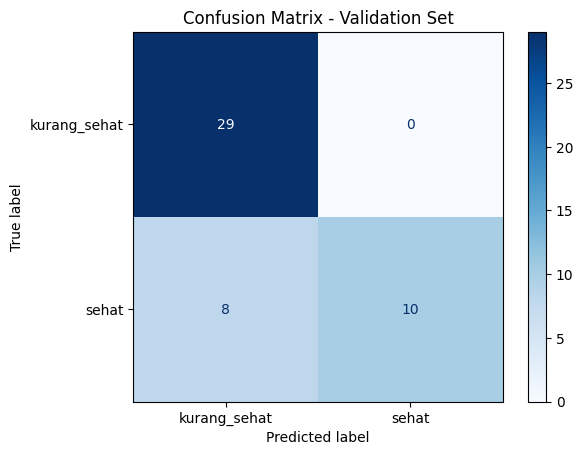

In [19]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Tampilkan confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.show()


# Inferensi Test set

In [20]:
resnet18.eval()
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

In [21]:
correct_test = np.sum(np.array(y_pred_test) == np.array(y_true_test))
total_test = len(y_true_test)
test_acc = 100 * correct_test / total_test
print(f'Test Accuracy: {test_acc:.2f}%')


Test Accuracy: 65.22%


<Figure size 600x600 with 0 Axes>

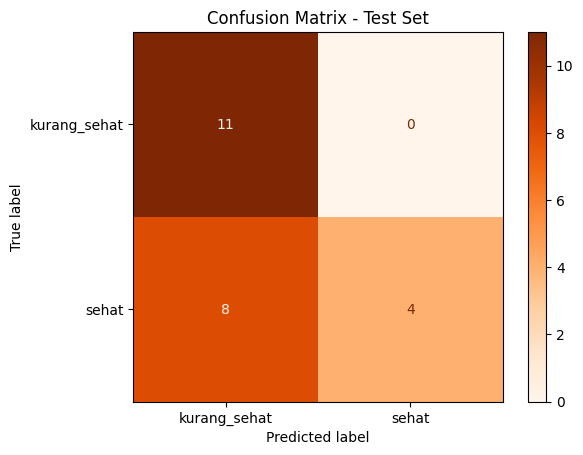

In [22]:
cm_test = confusion_matrix(y_true_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp_test.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

Saving Stand_10_png.rf.4566d19391b2424b7bb094936a844f7e_box3.jpg to Stand_10_png.rf.4566d19391b2424b7bb094936a844f7e_box3.jpg


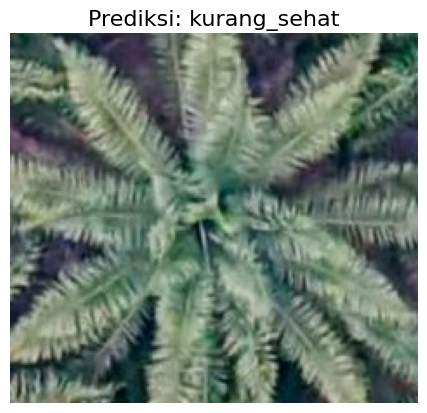

Hasil Prediksi: kurang_sehat


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from google.colab import files
import io

# Transformasi untuk prediksi
transform_predict = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Fungsi prediksi dari gambar langsung
def predict_image_pil(image):
    image_tensor = transform_predict(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = resnet18(image_tensor)
        _, predicted = torch.max(outputs, 1)

    label = class_names[predicted.item()]

    # Tampilkan gambar dan prediksi
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediksi: {label}", fontsize=16)
    plt.show()

    return label

# Upload gambar dari lokal
uploaded = files.upload()

# Ambil gambar pertama yang diupload
for fname in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fname])).convert("RGB")
    label = predict_image_pil(image)
    print(f"Hasil Prediksi: {label}")
    break  # hanya satu gambar dulu


In [ ]:
# Simpan model ke file lokal di Colab
model_path = 'resnet18_sawitNONDVI.pth'
torch.save(resnet18.state_dict(), model_path)
print(f"Model disimpan ke: {model_path}")


Model disimpan ke: resnet18_sawitNONDVI.pth


In [ ]:
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>